# Carbon Intensity Forecasting with XGBoost

## Packages and data loading

In [5]:
import warnings
from dataclasses import InitVar, dataclass, field

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [7]:
df1 = pd.read_csv("../Data/BE_C0220150101_20230116.csv")
df1

,Unnamed: 0,Biomass,Lignite,Gas,Coal,Oil,Geothermal,Hydro_storage,Hydro,Hydro_res,Nuclear,Other,Other_renew,Solar,Waste,Wind_off,Wind_on,Total,Carbon Intensity
0,2015-01-01 00:00:00+01:00,15.64,0.0,1526.672,480.240,0.0,0.0,287.765,0.396,0.0,14.375,412.3,0.0,0.000,186.9,6.591,2.301,2933.180,374.847284
1,2015-01-01 01:00:00+01:00,15.87,0.0,1510.418,479.136,0.0,0.0,131.427,0.396,0.0,14.375,466.2,0.0,0.000,188.3,6.383,2.665,2815.170,365.274426
2,2015-01-01 02:00:00+01:00,15.87,0.0,1482.726,480.240,0.0,0.0,0.000,0.396,0.0,14.370,463.4,0.0,0.000,189.7,6.747,2.808,2656.257,352.055268
3,2015-01-01 03:00:00+01:00,15.64,0.0,1350.286,481.344,0.0,0.0,0.000,0.396,0.0,14.365,444.5,0.0,0.000,186.2,6.877,3.081,2502.689,341.757340
4,2015-01-01 04:00:00+01:00,15.41,0.0,1284.668,481.344,0.0,0.0,0.000,0.407,0.0,14.370,417.9,0.0,0.000,187.6,5.291,4.238,2411.228,337.423454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70474,2023-01-15 10:00:00+01:00,27.83,0.0,248.024,0.000,0.0,0.0,0.000,0.066,0.0,24.505,0.0,0.0,26.425,72.8,26.338,27.859,453.847,43.355655
70475,2023-01-15 11:00:00+01:00,27.37,0.0,245.014,0.000,0.0,0.0,235.366,0.077,0.0,24.505,0.0,0.0,38.045,74.2,26.533,28.496,699.606,62.835100
70476,2023-01-15 12:00:00+01:00,27.60,0.0,244.412,0.000,0.0,0.0,0.000,0.077,0.0,24.545,0.0,0.0,37.835,74.9,25.792,29.042,464.203,42.791574
70477,2023-01-15 13:00:00+01:00,28.06,0.0,254.646,0.000,0.0,0.0,0.000,0.077,0.0,24.505,0.0,0.0,29.680,73.5,26.533,29.809,466.810,43.464618


In [194]:
color_pal = sns.color_palette()
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [195]:
df = pd.DataFrame()
df["Carbint"] = df1["Carbon Intensity"]
df["Datetime"] = df1["Unnamed: 0"]
df["Datetime"] = df.apply(lambda x: x["Datetime"][:-6], axis=1)

In [196]:
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)

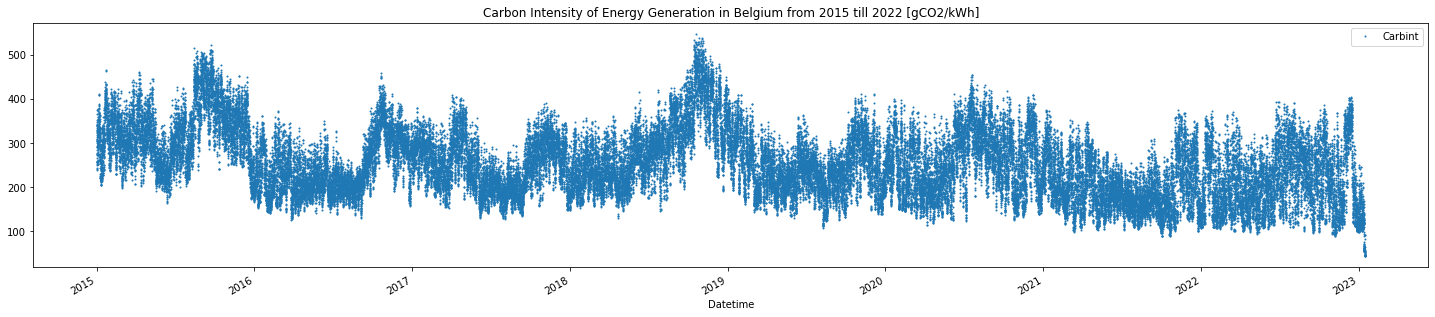

In [130]:
df.plot(
    style=".",
    figsize=(25, 5),
    color=color_pal[0],
    ms=2,
    title="Carbon Intensity of Energy Generation in Belgium from 2015 till 2022 [gCO2/kWh]",
    legend=["gCO2/kWh"],
)
plt.show()

## Train / Test split

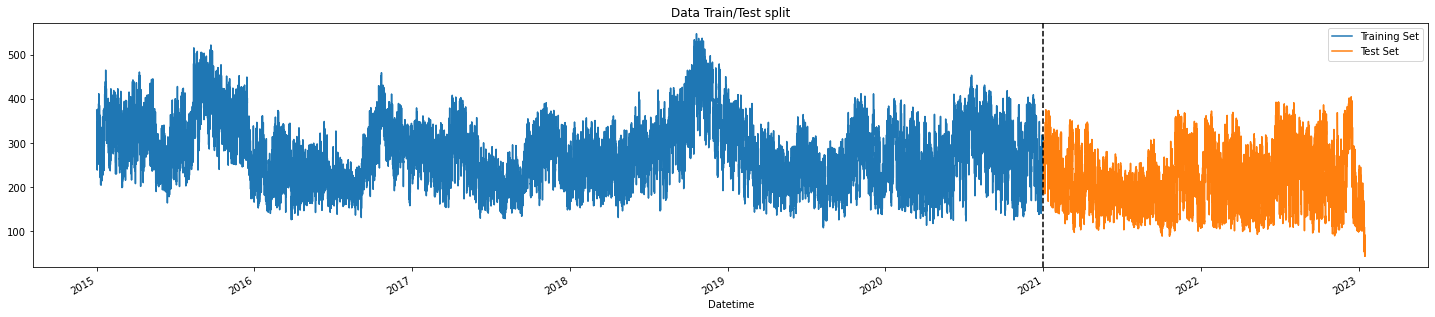

In [131]:
train = df.loc[df.index < "01-01-2021"]
test = df.loc[df.index >= " 01-01-2021"]

fig, ax = plt.subplots(figsize=(25, 5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test split")
test.plot(ax=ax, label="Test Set")
ax.axvline("01-01-2021", color="black", ls="--")
ax.legend(["Training Set", "Test Set"])
plt.show()

<AxesSubplot:title={'center':'Week of data'}, xlabel='Datetime'>

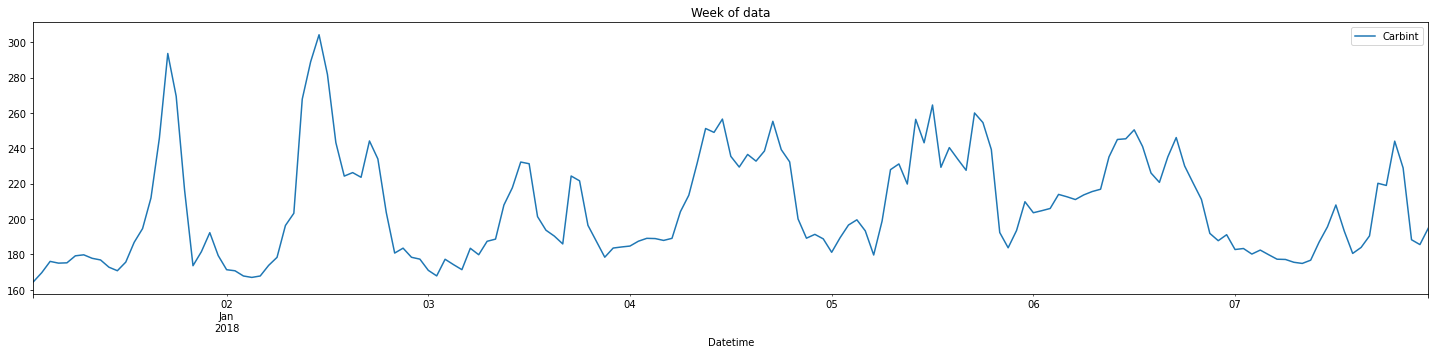

In [136]:
df.loc[(df.index > "01-01-2018") & (df.index < "01-08-2018")].plot(
    style="-",
    figsize=(25, 5),
    color=color_pal[0],
    ms=2,
    title="Week of data",
)

## Feature Creation

In [150]:
def create_feature(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.day
    return df

In [141]:
df = create_feature(df)

## Visualize Feature to Target Relationship

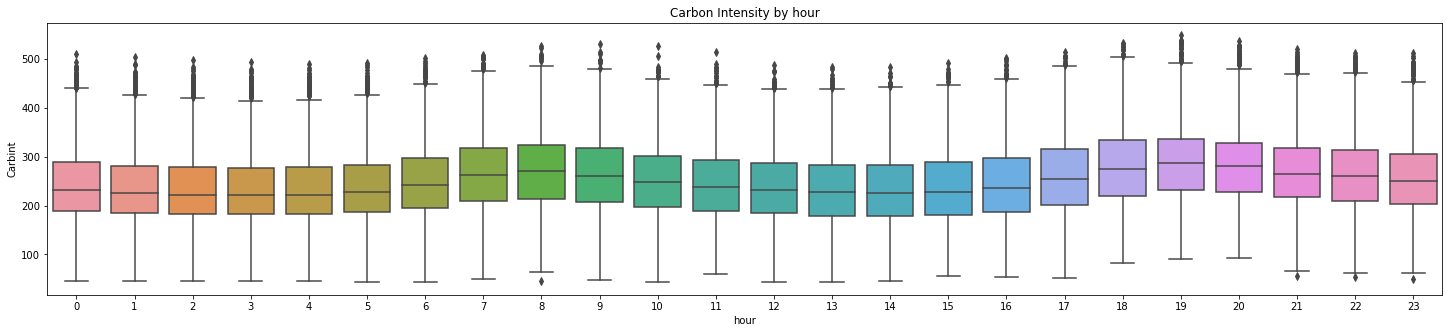

In [146]:
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(data=df, x="hour", y="Carbint")
ax.set_title("Carbon Intensity by hour")
plt.show()

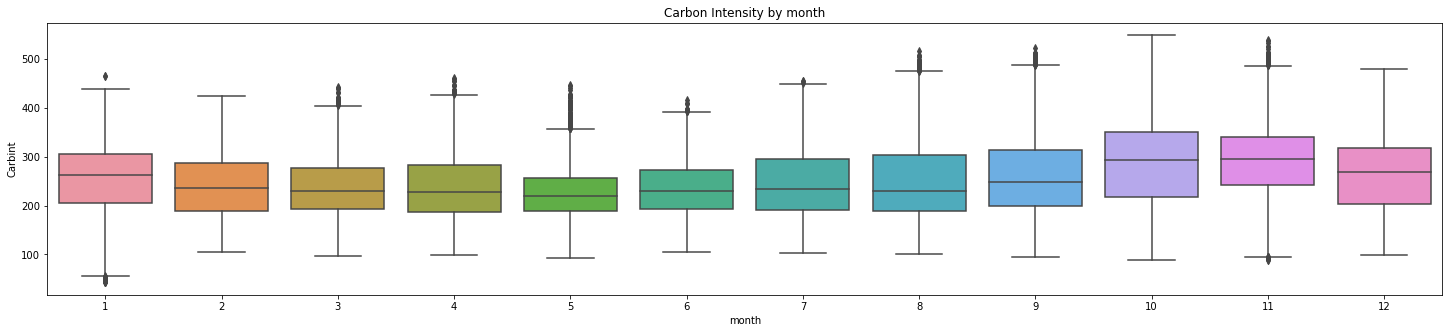

In [147]:
fig, ax = plt.subplots(figsize=(25, 5))
sns.boxplot(data=df, x="month", y="Carbint")
ax.set_title("Carbon Intensity by month")
plt.show()

## Model Creation

In [153]:
train = create_feature(train)
test = create_feature(test)

FEATURES = ["hour", "dayofweek", "quarter", "month", "year", "dayofyear"]
TARGET = "Carbint"

In [154]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [157]:
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping=50, learning_rate=0.1)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[22:31:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[0]	validation_0-rmse:250.28498	validation_1-rmse:190.06398
[100]	validation_0-rmse:30.97193	validation_1-rmse:82.94809
[200]	validation_0-rmse:26.01977	validation_1-rmse:85.34193
[300]	validation_0-rmse:23.52227	validation_1-rmse:86.09280
[400]	validation_0-rmse:21.68328	validation_1-rmse:86.54470
[500]	validation_0-rmse:20.28170	validation_1-rmse:86.89784
[600]	validation_0-rmse:19.23347	validation_1-rmse:87.09433
[700]	validation_0-rmse:18.35166	validation_1-rmse:87.24099
[800]	validation_0-rmse:17.61346	validation_1-rmse:87.39683
[900]	validation_0-rmse:17.02671	validation_1-rmse:87.49566
[1000]	validation_0-rmse:16.49032	validation_1-rmse:87.63749
[1100]	validation_0-rmse:16.01968	validation_1-rmse:87.78812
[1200]	validation_0-rmse:15.58779	validation_1-rmse:87.85017
[1300]	validation_0-rmse:15.20

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

## Feature Importance

In [162]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"]
)

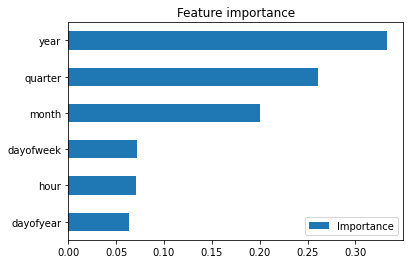

In [163]:
fi.sort_values("Importance").plot(kind="barh", title="Feature importance")
plt.show()

## Forecast on Test

In [164]:
test["prediction"] = reg.predict(X_test)

In [165]:
df = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

In [166]:
df

,Carbint,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,374.847284,0,3,1,1,2015,1,NaN
2015-01-01 01:00:00,365.274426,1,3,1,1,2015,1,NaN
2015-01-01 02:00:00,352.055268,2,3,1,1,2015,1,NaN
2015-01-01 03:00:00,341.757340,3,3,1,1,2015,1,NaN
2015-01-01 04:00:00,337.423454,4,3,1,1,2015,1,NaN
...,...,...,...,...,...,...,...,...
2023-01-15 10:00:00,43.355655,10,6,1,1,2023,15,169.509903
2023-01-15 11:00:00,62.835100,11,6,1,1,2023,15,170.620285
2023-01-15 12:00:00,42.791574,12,6,1,1,2023,15,167.405640


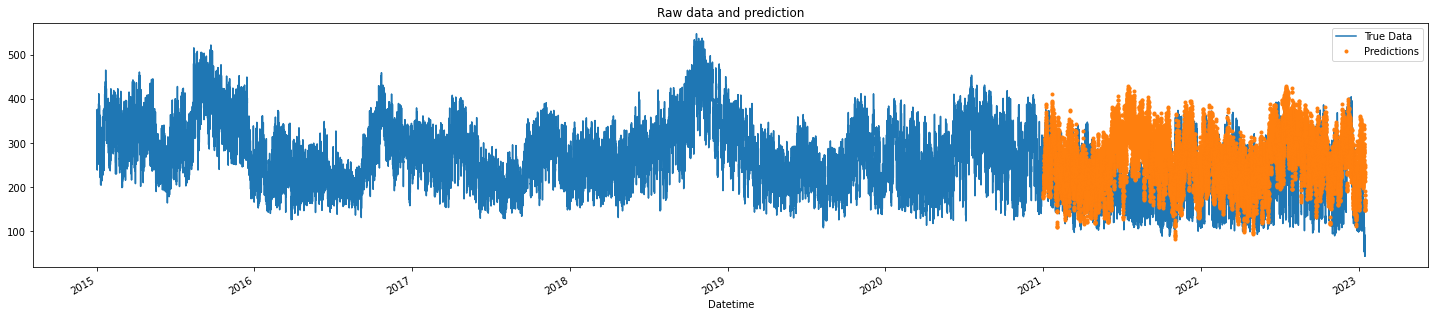

In [167]:
ax = df[["Carbint"]].plot(figsize=(25, 5))
df["prediction"].plot(ax=ax, style=".")
plt.legend(["True Data", "Predictions"])
ax.set_title("Raw data and prediction")
plt.show()

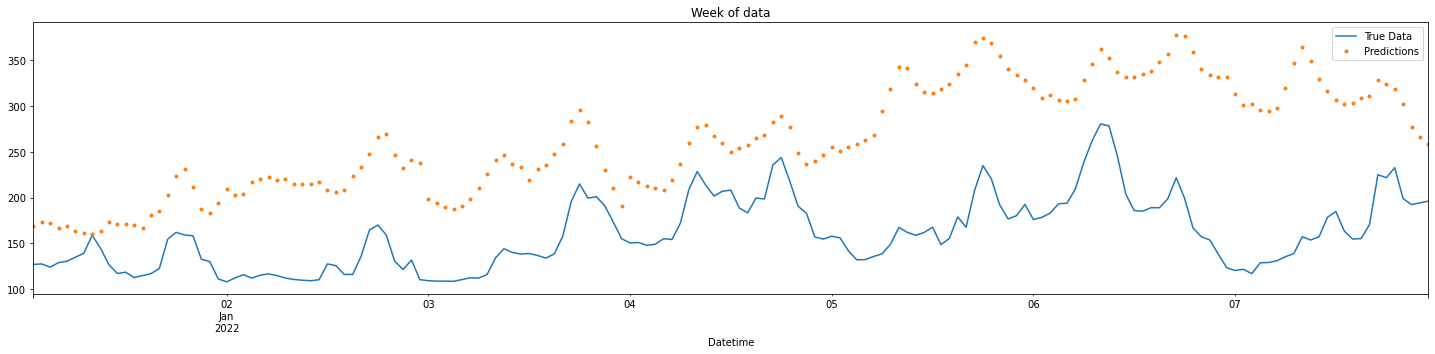

In [170]:
ax = df.loc[(df.index > "01-01-2022") & (df.index < "01-08-2022")]["Carbint"].plot(
    figsize=(25, 5),
    title="Week of data",
)
df.loc[(df.index > "01-01-2022") & (df.index < "01-08-2022")]["prediction"].plot(
    style="."
)
plt.legend(["True Data", "Predictions"])
plt.show()

In [173]:
score = np.sqrt(mean_squared_error(test["Carbint"], test["prediction"]))
print(f"RMS Score on Test set: {score:0.2f}")

RMS Score on Test set: 88.38


### Let's take a look at:
 - worst predicted days
 - best predicted days

In [174]:
test["error"] = np.abs(test[TARGET] - test["prediction"])

In [175]:
test["date"] = test.index.date

In [177]:
test.groupby("date")["error"].mean().sort_values(ascending=False).head(5)

date
2021-07-14    231.271482
2021-07-29    220.879344
2023-01-13    208.409174
2021-07-16    205.417937
2021-07-17    199.928699
Name: error, dtype: float64

In [178]:
test.groupby("date")["error"].mean().sort_values(ascending=True).head(5)

date
2022-12-06     9.183252
2021-05-28     9.888633
2022-03-01    11.500278
2021-05-11    11.883834
2022-03-26    12.693590
Name: error, dtype: float64

## Next steps
 - More robust cross validation
 - Add more features (weather, holidays)

## Outliers Analysis and Removal

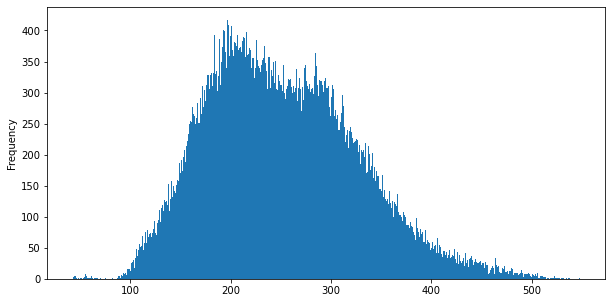

In [184]:
df["Carbint"].plot(kind="hist", bins=500, figsize=(10, 5))
plt.show()

<AxesSubplot:xlabel='Datetime'>

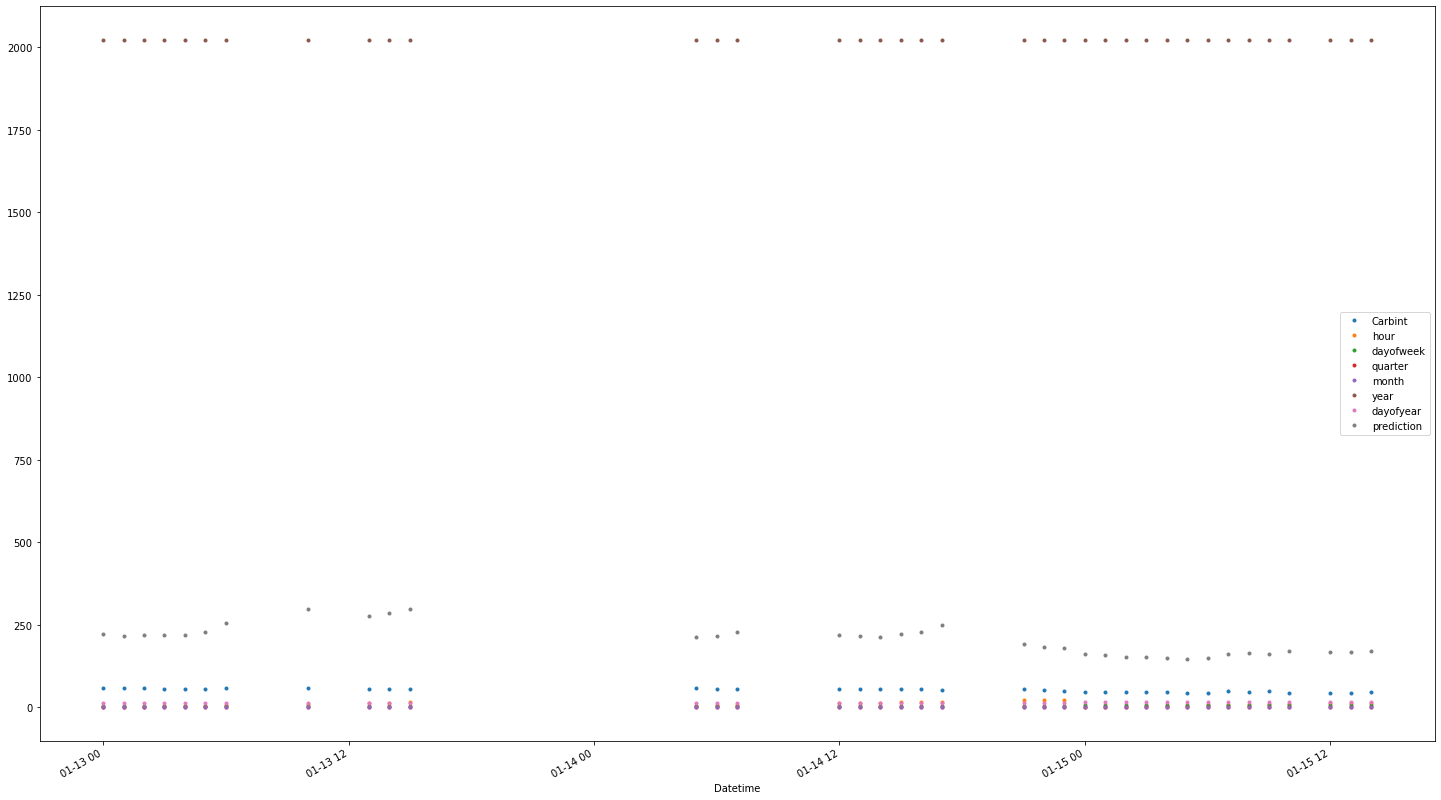

In [189]:
df.query("Carbint < 60").plot(figsize=(25, 15), style=".")

In [190]:
df = df.query("Carbint < 60").copy()

## Reviewing: Train / Test Split

### Time Series Cross Validation

In [191]:
from sklearn.model_selection import TimeSeriesSplit

In [192]:
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 365 * 1, gap=24)
df = df.sort_index()

In [197]:
for train_idx, val_idx in tss.split(df):
    break

In [198]:
train_idx

array([    0,     1,     2, ..., 26652, 26653, 26654])

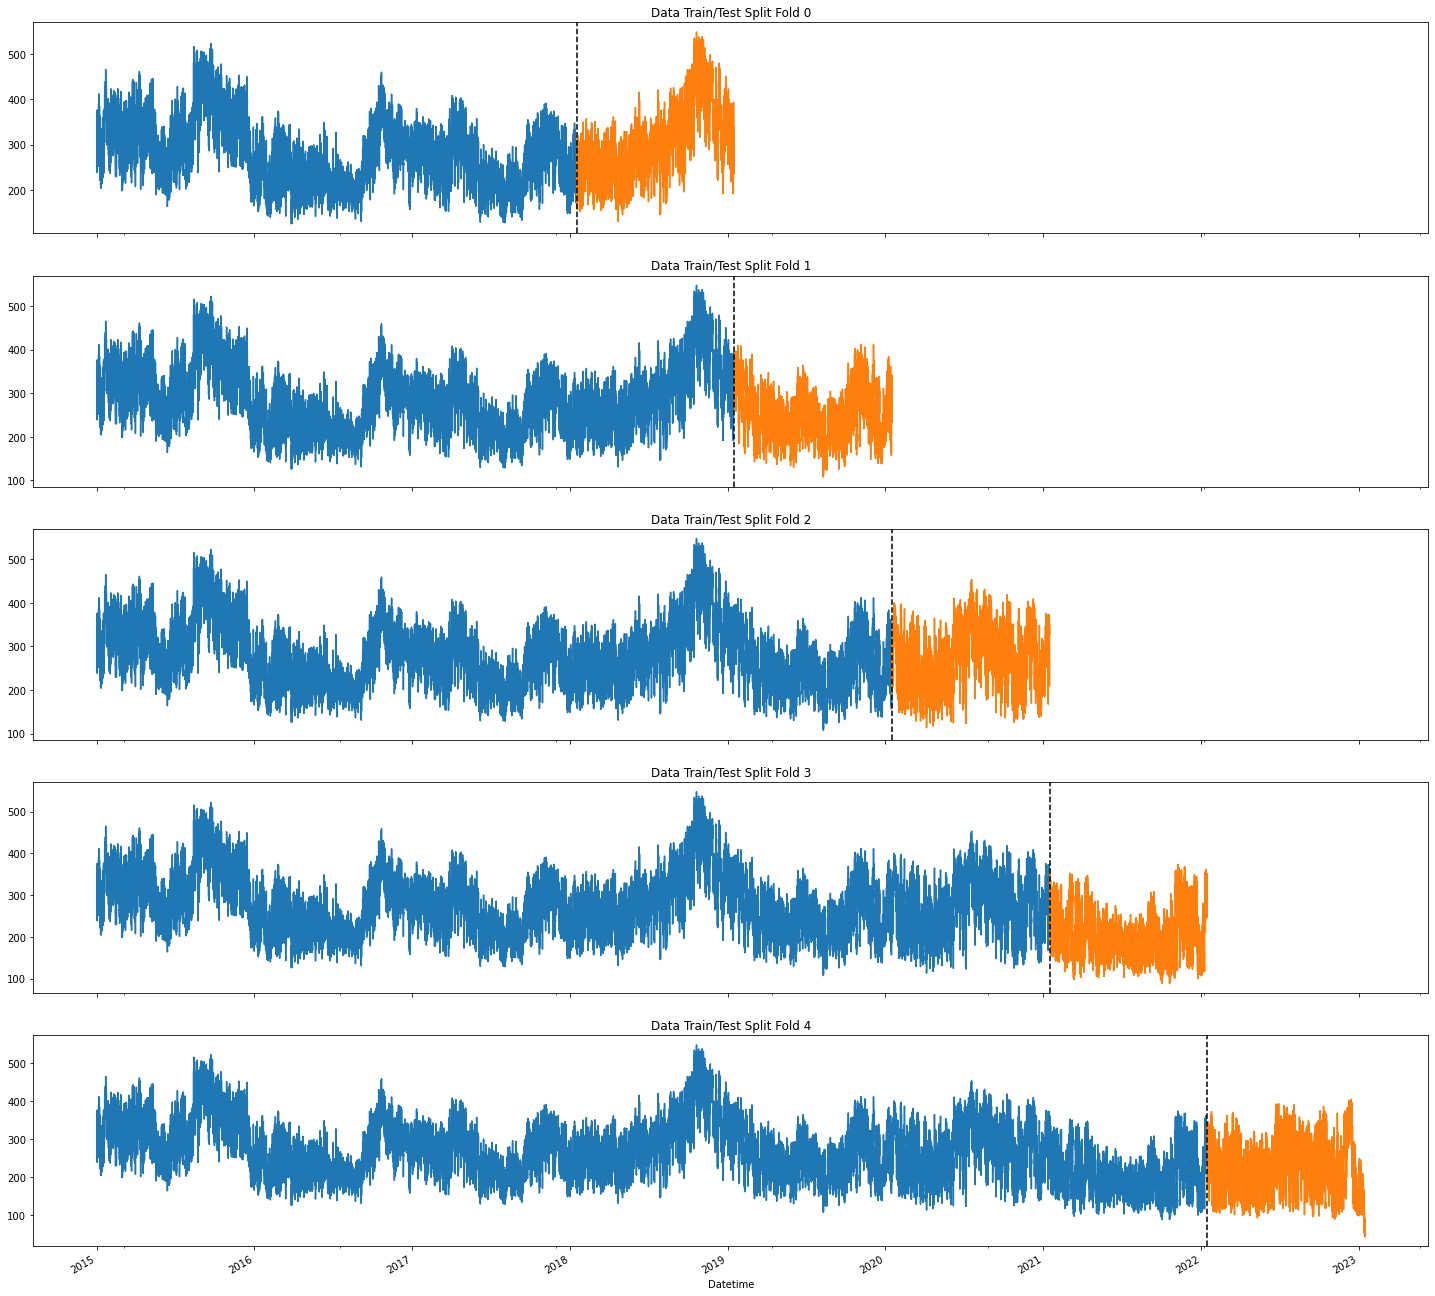

In [203]:
fig, axs = plt.subplots(5, 1, figsize=(25, 25), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["Carbint"].plot(
        ax=axs[fold], label="training set", title=f"Data Train/Test Split Fold {fold}"
    )
    test["Carbint"].plot(ax=axs[fold], label="Test set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")

    fold += 1

## Forecasting Horizon

In [215]:
def create_feature(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    # df["weekofyear"] = df.index.isocalendar().week
    return df


df = create_feature(df)

## Lag Features
 - what was the target (x) days in the past

In [206]:
def add_lags(df):
    target_map = df["Carbint"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    df["lag4"] = (df.index - pd.Timedelta("24 hours")).map(target_map)
    df["lag5"] = (df.index - pd.Timedelta("72 hours")).map(target_map)
    return df

In [208]:
df = add_lags(df)

In [211]:
df.tail()

,Carbint,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,lag4,lag5
Datetime,,,,,,,,,,,,,,
2023-01-15 10:00:00,43.355655,10,6,1,1,2023,15,15,2,229.294656,221.634922,242.265778,109.067551,120.624546
2023-01-15 11:00:00,62.835100,11,6,1,1,2023,15,15,2,223.879397,225.631846,249.723932,65.934665,119.500428
2023-01-15 12:00:00,42.791574,12,6,1,1,2023,15,15,2,228.476731,243.432707,220.770432,55.599182,119.016917
2023-01-15 13:00:00,43.464618,13,6,1,1,2023,15,15,2,212.102174,245.080741,228.251289,55.634253,117.377468
2023-01-15 14:00:00,44.899481,14,6,1,1,2023,15,15,2,210.798586,247.982158,242.914315,54.705871,118.101880


## Train Using Cross Validation

In [212]:
df.columns

Index(['Carbint', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5'],
      dtype='object')

In [221]:
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 365 * 1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_feature(train)
    test = create_feature(test)

    FEATURES = [
        "hour",
        "dayofweek",
        "quarter",
        "month",
        "year",
        "dayofyear",
        "dayofmonth",
        # "weekofyear",
        "lag1",
        "lag2",
        "lag3",
        "lag4",
        "lag5",
    ]
    TARGET = "Carbint"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.1,
        booster="gbtree",
        n_estimators=1000,
        early_stopping_rounds=50,
        objective="reg:linear",
        max_depth=3,
    )

    reg.fit(
        X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100
    )
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    fold += 1

[23:45:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:197.84726	validation_1-rmse:219.33569
[78]	validation_0-rmse:27.90025	validation_1-rmse:45.87208
[23:45:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:202.98016	validation_1-rmse:172.05719
[59]	validation_0-rmse:31.07163	validation_1-rmse:43.37342
[23:45:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:197.64110	validation_1-rmse:190.20516
[65]	validation_0-rmse:32.00767	validation_1-rmse:50.23692
[

In [225]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold scores {scores}")

Score across folds 43.4308
Fold scores [44.14252336620833, 37.38850517490097, 47.09906649829412, 41.60051621812208, 46.92336440541356]


## hyperparameter tuning

## Forecasting

In [231]:
df = create_feature(df)

FEATURES = [
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    # "weekofyear",
    "lag1",
    "lag2",
    "lag3",
    "lag4",
    "lag5",
]
TARGET = "Carbint"

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=2500,
    early_stopping_rounds=50,
    objective="reg:linear",
    max_depth=10,
)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[23:56:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:186.06277
[100]	validation_0-rmse:10.88838
[200]	validation_0-rmse:7.30065
[300]	validation_0-rmse:5.37363
[400]	validation_0-rmse:4.02794
[500]	validation_0-rmse:3.13165
[600]	validation_0-rmse:2.50188
[700]	validation_0-rmse:1.96535
[800]	validation_0-rmse:1.57801
[900]	validation_0-rmse:1.26514
[1000]	validation_0-rmse:1.02917
[1100]	validation_0-rmse:0.84064
[1200]	validation_0-rmse:0.71440
[1300]	validation_0-rmse:0.58563
[1400]	validation_0-rmse:0.49664
[1500]	validation_0-rmse:0.42595
[1600]	validation_0-rmse:0.35209
[1700]	validation_0-rmse:0.29393
[1800]	validation_0-rmse:0.25152
[1900]	validation_0-rmse:0.21261
[2000]	validation_0-rmse:0.18339
[2100]	validation_0-rmse:0.15729
[2200]	validation_0-rmse:0.13534
[2300]	validation_0-rmse:0.11777
[24

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [232]:
df.index.max()

Timestamp('2023-01-15 14:00:00')

In [237]:
future = pd.date_range("2023-01-15", "2024-01-01", freq="1h")
future_df = pd.DataFrame(index=future)
future_df["isFuture"] = True
df["isFuture"] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)

In [238]:
future_w_features = df_and_future.query("isFuture").copy()

In [239]:
future_w_features

,Carbint,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,lag4,lag5,isFuture
2023-01-15 00:00:00,NaN,0,6,1,1,2023,15,15,<NA>,224.735349,229.741645,252.410362,67.308551,106.155222,True
2023-01-15 01:00:00,NaN,1,6,1,1,2023,15,15,<NA>,208.945621,213.298727,247.854804,75.418088,105.643228,True
2023-01-15 02:00:00,NaN,2,6,1,1,2023,15,15,<NA>,170.627300,208.699826,237.524837,70.330828,106.676727,True
2023-01-15 03:00:00,NaN,3,6,1,1,2023,15,15,<NA>,170.673979,200.188322,233.451377,66.077773,104.578909,True
2023-01-15 04:00:00,NaN,4,6,1,1,2023,15,15,<NA>,178.484017,194.840682,219.079019,61.874206,109.367824,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:00:00,NaN,20,6,4,12,2023,365,31,<NA>,204.852775,130.398057,194.273831,NaN,NaN,True
2023-12-31 21:00:00,NaN,21,6,4,12,2023,365,31,<NA>,125.269414,121.360266,204.789372,NaN,NaN,True
2023-12-31 22:00:00,NaN,22,6,4,12,2023,365,31,<NA>,118.161202,131.640510,219.411697,NaN,NaN,True
2023-12-31 23:00:00,NaN,23,6,4,12,2023,365,31,<NA>,117.675036,110.194387,205.516563,NaN,NaN,True


## Run prediction

In [240]:
future_w_features["pred"] = reg.predict(future_w_features[FEATURES])

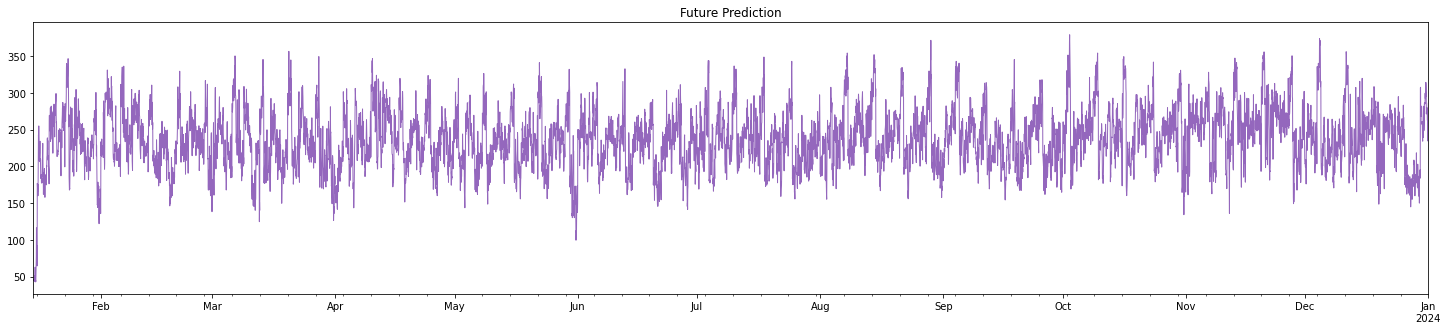

In [243]:
future_w_features["pred"].plot(
    figsize=(25, 5),
    color=color_pal[4],
    ms=1,
    lw=1,
    title="Future Prediction",
    style="-",
)
plt.show()

In [245]:
reg.save_model('model.json')

In [246]:
!ls -lh

total 694792
-rw-r--r--  1 hubertstinia  staff    47K Jan 15 16:19 BE_C02.csv
-rw-r--r--  1 hubertstinia  staff   9.7M Jan 15 16:43 BE_C0220150101_20230116.csv
-rw-r--r--  1 hubertstinia  staff    43K Jan 15 16:19 BE_gen.csv
-rw-r--r--  1 hubertstinia  staff   8.7M Jan 15 16:43 BE_gen20150101_20230116.csv
-rw-r--r--  1 hubertstinia  staff    28K Jan 15 16:19 BE_gen_RAW.csv
-rw-r--r--  1 hubertstinia  staff   6.3M Jan 15 16:43 BE_gen_RAW20150101_20230116.csv
-rw-r--r--  1 hubertstinia  staff   6.9M Jan 15 18:09 BE_load_RAW20150101_20230116.csv
-rw-r--r--  1 hubertstinia  staff   1.7K Jan 15 17:56 BE_load_RAW20230115_20230116.csv
-rw-r--r--  1 hubertstinia  staff   2.1M Jan 15 18:11 BE_price_RAW20150101_20230116.csv
-rw-r--r--  1 hubertstinia  staff   764B Jan 15 17:56 BE_price_RAW20230115_20230116.csv
-rw-r--r--  1 hubertstinia  staff   1.0M Jan 16 00:10 CARB_XGB.ipynb
-rw-r--r--  1 hubertstinia  staff    46M Jan 15 17:05 DE_C0220150101_20230116.csv
-rw-r--r--  1 hubertstinia  staff    

In [248]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

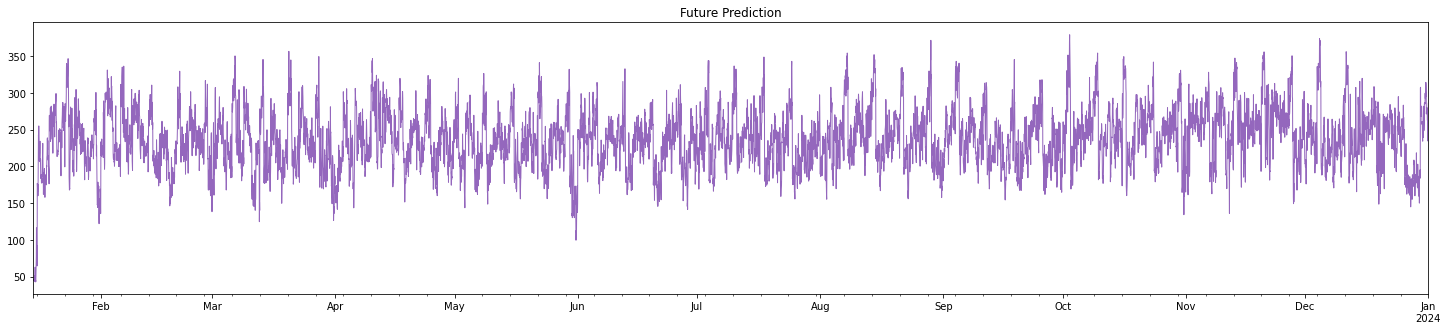

In [249]:
future_w_features["pred"] = reg_new.predict(future_w_features[FEATURES])
future_w_features["pred"].plot(
    figsize=(25, 5),
    color=color_pal[4],
    ms=1,
    lw=1,
    title="Future Prediction",
    style="-",
)
plt.show()